## Restricted Botlzman Machines (RBM)

In [30]:
#FIXME: Review the generation process (theoretically) and fix the implementation 

In [31]:
import os
from typing import List, Dict, Tuple, Literal, Optional, Union, Iterable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from numpy._typing import ArrayLike

ArrayLike = Union[List, Tuple, np.ndarray]

In [32]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

if not os.path.exists(ALPHA_DIGIT_PATH):
    raise FileNotFoundError(f"The file {ALPHA_DIGIT_PATH} does not exist.")

### 3.1 Implementing a RBM and testing on Binary AlphaDigits

In [33]:
def _load_data(file_path: str) -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.

    Returns:
    - data (dict): Loaded data dictionary.
    """
    if file_path is None:
        raise ValueError("File path must be provided.")

    return scipy.io.loadmat(file_path)


data = _load_data(ALPHA_DIGIT_PATH)
class_labels = data["classlabels"].flatten() 
class_count = data["classcounts"].flatten()
df = pd.DataFrame(
    {
        "Class Labels": class_labels,
        "Class Count": class_count
    }
)
df["Class Labels"] = df["Class Labels"].apply(lambda x: x[0])
df["Class Count"] = df["Class Count"].apply(lambda x: x[0][0])
df

,Class Labels,Class Count
0,0,39
1,1,39
2,2,39
3,3,39
4,4,39
5,5,39
6,6,39
7,7,39
8,8,39
9,9,39


In [34]:
def _load_data(file_path: str, which: Literal["alphadigit", "mnist"]="alphadigit") -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.
    - which (Literal["alphadigit", "mnist"], optional): Specifies 
        which data to load. The default value is "alphadigit".

    Returns:
    - data (dict): A dictionary containing the loaded data.

    Raises:
    - ValueError: If the file_path parameter is None.
    - ValueError: If the which parameter is not "alphadigit".

    Example Usage:
    ```python
    data = _load_data("data.mat", "alphadigit")
    ```
    """
    if file_path is None:
        raise ValueError("File path must be provided.")
    
    if which == "alphadigit":
        return scipy.io.loadmat(file_path)["dat"]
    
    raise ValueError("MNIST NOT YET AVAILABLE.")

alphadigit_data = _load_data(ALPHA_DIGIT_PATH) 
print(alphadigit_data.shape)
print(alphadigit_data[0][0].shape)

(36, 39)
(20, 16)


In [35]:
def _map_characters_to_indices(characters: Union[str, int, List[Union[str, int]]]) -> List[int]:
    """
    Map alphanumeric character to its corresponding index.

    Parameters:
    - character (str, int, list of str or int): Alphanumeric character or its index.

    Returns:
    - char_index (int): Corresponding index for the character.
    """
    if isinstance(characters, list):
        return [_map_characters_to_indices(char) for char in characters]
    if isinstance(characters, int) and 0 <= characters <= 35:
        return [characters]
    if (isinstance(characters, str) and characters.isdigit()
          and 0 <= int(characters) <= 9):
        return [int(characters)]
    if (isinstance(characters, str) and characters.isalpha()
          and 'A' <= characters.upper() <= 'Z'):
        return [ord(characters.upper()) - ord('A') + 10]
    
    raise ValueError(
        "Invalid character input. It should be an alphanumeric" 
        "character '[0-9|A-Z]' or its index representing '[0-35]'."
    )

for char in [0, 10, "A", [1, "C"], 36]:
    try:
        map = _map_characters_to_indices(char)
        print(f"{char} > map to > {map}")
    except:
        print(f"{char} > no mapping available, out of range")

0 > map to > [0]
10 > map to > [10]
A > map to > [10]
[1, 'C'] > map to > [[1], [12]]
36 > no mapping available, out of range


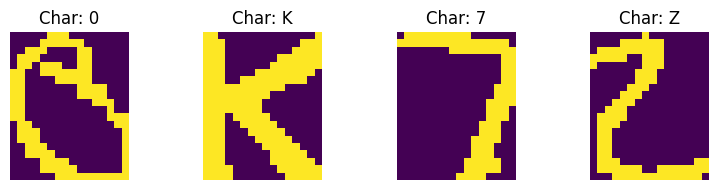

In [36]:
def read_alpha_digit(characters: Optional[Union[str, int, List[Union[str, int]]]] = None,
                     file_path: Optional[str] = ALPHA_DIGIT_PATH,
                     data: Optional[Dict[str, np.ndarray]] = None,
                     use_data: bool = False,
                     ) -> np.ndarray:
    """
    Reads binary AlphaDigits data from a .mat file or uses already loaded data. 
    It extracts the data for a specified alphanumeric character or its index, and 
    flattens the images into one-dimensional vectors.

    Parameters:
    - characters (Union[str, int, List[Union[str, int]]], optional): Alphanumeric character 
        or its index whose data needs to be extracted. It can be a single character or 
        a list of characters. Default is None.
    - file_path (str, optional): Path to the .mat file containing the data. 
        Default is None.
    - data (dict, optional): Already loaded data dictionary. 
        Default is None.
    - use_data (bool): Flag to indicate whether to use already loaded data.
        Default is False.

    Returns:
    - flattened_images (numpy.ndarray): Flattened images for the specified character(s).
    """
    if not use_data:
        data = _load_data(file_path, which="alphadigit")

    char_indices = _map_characters_to_indices(characters)

    # Select the rows corresponding to the characters indices.
    char_data: np.ndarray = data[char_indices]
    
    # Flatten each image into a one-dimensional vector.
    flattened_images = np.array([image.flatten() for image in char_data.flatten()])
    return flattened_images

def plot_characters(chars, data):
    num_chars = len(chars)
    num_images_per_char = data.shape[0] // num_chars
    fig, ax = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))

    for i, char in enumerate(chars):
        # Find the index of the first image corresponding to the current char
        start_index = i * num_images_per_char
        image = data[start_index].reshape(20, 16)
        ax[i].imshow(image)
        ax[i].set_title(f'Char: {char}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example
chars = [0, "K", 7, "Z"]
data = read_alpha_digit(chars, data=alphadigit_data, use_data=True)
plot_characters(chars, data)

In [37]:
print("data shape:", data.shape)

data shape: (156, 320)


In [38]:
class RBM:
    def __init__(self, n_visible: int, n_hidden: int=100, random_state=None) -> None:
        """
        Initialize the Restricted Boltzmann Machine.

        Parameters:
        - n_visible (int): Number of visible units.
        - n_hidden (int): Number of hidden units. Default 100.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        self.a = np.zeros((1, n_visible)) # visible_bias
        self.b = np.zeros((1, n_hidden)) # hidden_bias
        self.rng = np.random.default_rng(random_state)
        self.W = 1e-4 * self.rng.standard_normal(size=(n_visible, n_hidden)) # weights

    def __repr__(self) -> str:
        return f"RBM(n_visible={self.n_visible}, n_hidden={self.n_hidden})"

    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation function.

        Parameters:
        - x (numpy.ndarray): Input array.

        Returns:
        - numpy.ndarray: Result of applying the sigmoid function to the input.
        """
        return 1 / (1 + np.exp(-x))
    
    def _reconstruction_error(self, input: np.ndarray, image: np.ndarray) -> float:
        """
        Compute reconstruction error.

        Parameters:
        - input (numpy.ndarray): Original input data.
        - image (numpy.ndarray): Reconstructed image.

        Returns:
        - float: Reconstruction error.
        """
        return np.round(np.power(image - input, 2).mean(), 5)

    def input_output(self, data: np.ndarray) -> np.ndarray:
        """
        Compute hidden units given visible units.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - numpy.ndarray: Hidden unit activations, shape (n_samples, n_hidden).
        """
        return self._sigmoid(data @ self.W + self.b)

    def output_input(self, data_h: np.ndarray) -> np.ndarray:
        """
        Compute visible units given hidden units.

        Parameters:
        - data_h (numpy.ndarray): Hidden unit activations, shape (n_samples, n_hidden).

        Returns:
        - numpy.ndarray: Reconstructed visible units, shape (n_samples, n_visible).
        """
        return self._sigmoid(data_h @ self.W.T + self.a)
    
    def calcul_softmax(self, data: np.ndarray) -> np.ndarray:
        """
        Calculate softmax probabilities for the output units.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - numpy.ndarray: Softmax probabilities, shape (n_samples, n_hidden).
        """
        # Compute activations for the hidden layer
        hidden_activations = self.input_output(data)
        
        # Compute softmax probabilities for the output layer
        exp_hidden_activations = np.exp(hidden_activations)
        softmax_probs = exp_hidden_activations / np.sum(exp_hidden_activations, axis=1, keepdims=True)
        
        return softmax_probs

    def update(
            self, 
            batch: np.ndarray,
            learning_rate: float=0.1,
            batch_size: Optional[int]=None,
            return_output: bool=False
        ):
        """_summary_

        Args:
            batch (np.ndarray): _description_
            learning_rate (float, optional): _description_. Defaults to 0.1.
            batch_size (Optional[int], optional): _description_. Defaults to None.
            return_output (bool, optional): _description_. Defaults to False.
        """
        if not batch_size:
            batch_size = batch.shape[0]
        pos_h_probs = self.input_output(batch)
        pos_v_probs = self.output_input(pos_h_probs)
        neg_h_probs = self.input_output(pos_v_probs)
        
        # Update weights and biases
        self.W += learning_rate * (batch.T @ pos_h_probs - pos_v_probs.T @ neg_h_probs) / batch_size
        self.b += learning_rate * (pos_h_probs - neg_h_probs).mean(axis=0)
        self.a += learning_rate * (batch - pos_v_probs).mean(axis=0)

        if return_output:
            return self, pos_v_probs
        
        return self 

    def train(self, 
              data: np.ndarray,
              learning_rate: float=0.1,
              n_epochs: int=10,
              batch_size: int=10,
              print_each=10
        ) -> 'RBM':
        """
        Train the RBM using Contrastive Divergence.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.

        Returns:
        - RBM: Trained RBM instance.
        """
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            self.rng.shuffle(data)
            for i in tqdm(range(0, n_samples, batch_size), desc=f"Epoch {epoch}"):
                batch = data[i:i+batch_size]
                _, pos_v_probs = self.update(
                    batch=batch,
                    learning_rate=learning_rate,
                    batch_size=batch_size,
                    return_output=True
                )
                
            if epoch % print_each == 0:
                tqdm.write(
                    f"Reconstruction error: {self._reconstruction_error(batch, pos_v_probs)}.")

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the RBM using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 10.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 1.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        samples = np.zeros((n_samples, self.n_visible))
        
        # Matrix of initlization value of Gibbs samples for each sample. 
        V = self.rng.binomial(1, self.rng.random(), size=n_samples*self.n_visible).reshape((n_samples, self.n_visible))
        for i in range(n_samples):
            for _ in range(n_gibbs_steps):
                h_probs = self._sigmoid(V[i] @ self.W + self.b) # vector
                h = self.rng.binomial(1, h_probs)
                v_probs = self._sigmoid(h @ self.W.T + self.a)
                v = self.rng.binomial(1, v_probs)
            samples[i] = v
        return samples

In [39]:
# Load the alpha_digit data
data = read_alpha_digit(file_path=ALPHA_DIGIT_PATH, characters=['Z'])

In [40]:
# Parameters
n_visible = data.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=42)
print(rbm)

# Train RBM
rbm.train(data, learning_rate=0.1, n_epochs=500, batch_size=10)

RBM(n_visible=320, n_hidden=200)


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 74.07it/s]


Reconstruction error: 0.16569.


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 571.66it/s]


Reconstruction error: 0.13308.


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 666.69it/s]


Reconstruction error: 0.11447.


Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 571.37it/s]


Reconstruction error: 0.0752.


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 571.18it/s]


Reconstruction error: 0.05648.


Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 666.74it/s]


Reconstruction error: 0.04929.


Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 666.45it/s]


Reconstruction error: 0.04607.


Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 500.23it/s]


Reconstruction error: 0.02899.


Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 666.40it/s]


Reconstruction error: 0.01998.


Epoch 90: 100%|██████████| 4/4 [00:00<00:00, 799.98it/s]


Reconstruction error: 0.01886.


Epoch 100: 100%|██████████| 4/4 [00:00<00:00, 400.17it/s]


Reconstruction error: 0.01225.


Epoch 110: 100%|██████████| 4/4 [00:00<00:00, 800.78it/s]


Reconstruction error: 0.00928.


Epoch 120: 100%|██████████| 4/4 [00:00<00:00, 666.74it/s]


Reconstruction error: 0.00509.


Epoch 130: 100%|██████████| 4/4 [00:00<00:00, 666.93it/s]


Reconstruction error: 0.00601.


Epoch 140: 100%|██████████| 4/4 [00:00<00:00, 799.75it/s]


Reconstruction error: 0.00398.


Epoch 150: 100%|██████████| 4/4 [00:00<00:00, 800.06it/s]


Reconstruction error: 0.00366.


Epoch 160: 100%|██████████| 4/4 [00:00<00:00, 799.71it/s]


Reconstruction error: 0.00274.


Epoch 170: 100%|██████████| 4/4 [00:00<00:00, 571.72it/s]


Reconstruction error: 0.0018.


Epoch 180: 100%|██████████| 4/4 [00:00<00:00, 800.13it/s]


Reconstruction error: 0.00159.


Epoch 190: 100%|██████████| 4/4 [00:00<00:00, 800.17it/s]


Reconstruction error: 0.00206.


Epoch 200: 100%|██████████| 4/4 [00:00<00:00, 499.96it/s]


Reconstruction error: 0.0011.


Epoch 210: 100%|██████████| 4/4 [00:00<00:00, 630.94it/s]


Reconstruction error: 0.00116.


Epoch 220: 100%|██████████| 4/4 [00:00<00:00, 687.93it/s]


Reconstruction error: 0.00068.


Epoch 230: 100%|██████████| 4/4 [00:00<00:00, 666.79it/s]


Reconstruction error: 0.00066.


Epoch 240: 100%|██████████| 4/4 [00:00<00:00, 799.71it/s]


Reconstruction error: 0.00054.


Epoch 250: 100%|██████████| 4/4 [00:00<00:00, 571.45it/s]


Reconstruction error: 0.00059.


Epoch 260: 100%|██████████| 4/4 [00:00<00:00, 799.68it/s]


Reconstruction error: 0.00051.


Epoch 270: 100%|██████████| 4/4 [00:00<00:00, 571.43it/s]


Reconstruction error: 0.00052.


Epoch 280: 100%|██████████| 4/4 [00:00<00:00, 666.53it/s]


Reconstruction error: 0.00035.


Epoch 290: 100%|██████████| 4/4 [00:00<00:00, 666.61it/s]


Reconstruction error: 0.00035.


Epoch 300: 100%|██████████| 4/4 [00:00<00:00, 571.53it/s]


Reconstruction error: 0.00029.


Epoch 310: 100%|██████████| 4/4 [00:00<00:00, 666.77it/s]


Reconstruction error: 0.0003.


Epoch 320: 100%|██████████| 4/4 [00:00<00:00, 666.61it/s]


Reconstruction error: 0.00022.


Epoch 330: 100%|██████████| 4/4 [00:00<00:00, 505.61it/s]


Reconstruction error: 0.00025.


Epoch 340: 100%|██████████| 4/4 [00:00<00:00, 569.14it/s]


Reconstruction error: 0.00022.


Epoch 350: 100%|██████████| 4/4 [00:00<00:00, 444.35it/s]


Reconstruction error: 0.00022.


Epoch 360: 100%|██████████| 4/4 [00:00<00:00, 500.26it/s]


Reconstruction error: 0.00017.


Epoch 370: 100%|██████████| 4/4 [00:00<00:00, 800.55it/s]


Reconstruction error: 0.00017.


Epoch 380: 100%|██████████| 4/4 [00:00<00:00, 666.95it/s]


Reconstruction error: 0.0002.


Epoch 390: 100%|██████████| 4/4 [00:00<00:00, 666.66it/s]


Reconstruction error: 0.00021.


Epoch 400: 100%|██████████| 4/4 [00:00<00:00, 444.56it/s]


Reconstruction error: 0.00017.


Epoch 410: 100%|██████████| 4/4 [00:00<00:00, 399.89it/s]


Reconstruction error: 0.00011.


Epoch 420: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.00016.


Epoch 430: 100%|██████████| 4/4 [00:00<00:00, 666.79it/s]


Reconstruction error: 0.00012.


Epoch 440: 100%|██████████| 4/4 [00:00<00:00, 800.06it/s]


Reconstruction error: 0.00012.


Epoch 450: 100%|██████████| 4/4 [00:00<00:00, 666.69it/s]


Reconstruction error: 0.00013.


Epoch 460: 100%|██████████| 4/4 [00:00<00:00, 571.47it/s]


Reconstruction error: 0.00012.


Epoch 470: 100%|██████████| 4/4 [00:00<00:00, 800.25it/s]


Reconstruction error: 0.0001.


Epoch 480: 100%|██████████| 4/4 [00:00<00:00, 571.66it/s]


Reconstruction error: 9e-05.


Epoch 490: 100%|██████████| 4/4 [00:00<00:00, 666.82it/s]


Reconstruction error: 8e-05.


Epoch 499: 100%|██████████| 4/4 [00:00<00:00, 611.15it/s]


RBM(n_visible=320, n_hidden=200)

In [41]:
np.testing.assert_allclose(rbm.calcul_softmax(data).sum(1), 1)

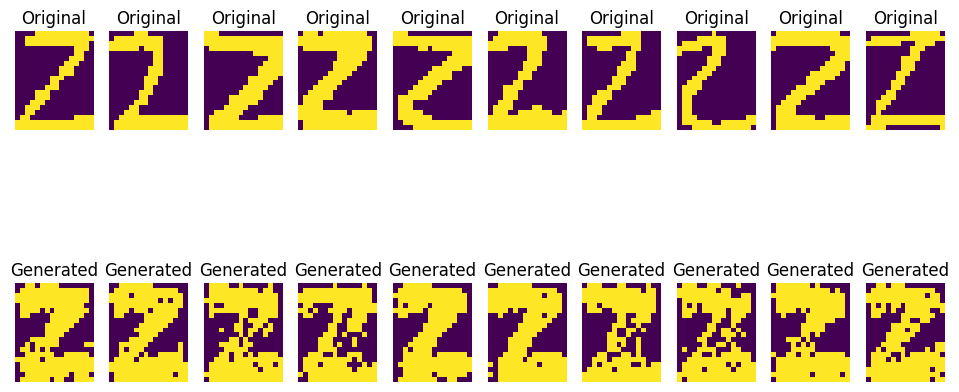

In [42]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

# Plot original and generated samples
plt.figure(figsize=(12, 6))

n_images = 10
for i in range(n_images):
    plt.subplot(2, n_images, i + 1)
    plt.imshow(data[i].reshape(20, 16))
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(generated_samples[i].reshape(20, 16))
    plt.title('Generated')
    plt.axis('off')

plt.show()

In [43]:
print(rbm)

RBM(n_visible=320, n_hidden=200)


### 3.2 Implementing a Deep Belief Network (DBN) and test on Binary AlphaDigits

In [44]:
class DBN:
    def __init__(self, n_visible: int, hidden_layer_sizes: list[int], random_state=None):
        """
        Initialize the Deep Belief Network.

        Parameters:
        - n_visible (int): Number of visible units.
        - hidden_layer_sizes (list[int]): List of sizes for each hidden layer.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.hidden_layer_sizes = hidden_layer_sizes
        self.rbms: List[RBM] = []
        self.rng = np.random.default_rng(random_state)

        # Initialize the first RBM
        first_rbm = RBM(
            n_visible=n_visible,
            n_hidden=hidden_layer_sizes[0],
            random_state=random_state,
        )
        self.rbms.append(first_rbm)

        # Initialize RBMs for subsequent hidden layers
        for i, size in enumerate(hidden_layer_sizes[1:], start=1):
            rbm = RBM(
                n_visible=hidden_layer_sizes[i - 1],
                n_hidden=size,
                random_state=random_state,
            )
            self.rbms.append(rbm)


    def __getitem__(self, key):
        return self.rbms[key]
    

    def __repr__(self):
        """
        Return a string representation of the DBN object.
        """
        rbm_reprs = [f"{'':4}{repr(rbm)}" for rbm in self.rbms]
        join_rbm_reprs = ',\n'.join(rbm_reprs)
        return f"DBN([\n{join_rbm_reprs}\n])"


    def train(self,
        data: np.ndarray,
        learning_rate: float=0.1,
        n_epochs: int=10,
        batch_size: int=10,
        print_each: int=10,
    ) -> "DBN":
        """
        Train the DBN using Greedy layer-wise procedure.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.
        - print_each: Print reconstruction error each `print_each` epochs.
        - verbose

        Returns:
        - DBN: Trained DBN instance.
        """
        input_data = data
        for rbm in self.rbms:
            rbm.train(
                input_data,
                learning_rate=learning_rate,
                n_epochs=n_epochs,
                batch_size=batch_size,
                print_each=print_each,
            )
            # Update input data for the next RBM
            input_data = rbm.input_output(input_data)

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the DBN using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 1.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 1.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        # samples = np.zeros((n_samples, self.n_visible))

        # Generate samples using the first RBM in the DBN
        samples = self.rbms[-1].generate_image(n_samples, n_gibbs_steps)
        for rbm in reversed(self.rbms[:-1]):
            # Sample from the conditional probability of layer l-1 given layer l: p(h_{s-1}|h_{s}).
            h_probs = rbm.output_input(samples)
            h = self.rng.binomial(1, p=h_probs) 
            samples = h
        return samples

In [45]:
# from principal_dbn_alpha import DBN

In [46]:
n_visible=data.shape[1]
hidden_layer_sizes = [100, 50, 25]

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
dbn.train(data, learning_rate=0.1, n_epochs=100, batch_size=10)

Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 333.36it/s]


Reconstruction error: 0.15919.


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 41.66it/s]


Reconstruction error: 0.15141.


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 571.51it/s]


Reconstruction error: 0.00677.


Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 823.83it/s]


Reconstruction error: 0.09389.


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 999.89it/s]


Reconstruction error: 0.06596.


Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 148.15it/s]


Reconstruction error: 0.04872.


Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.04716.


Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 799.94it/s]


Reconstruction error: 0.0338.


Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 666.71it/s]


Reconstruction error: 0.0301.


Epoch 90: 100%|██████████| 4/4 [00:00<00:00, 799.75it/s]


Reconstruction error: 0.02988.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 3998.38it/s]


Reconstruction error: 0.18585.


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 3997.43it/s]


Reconstruction error: 0.18626.


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 3994.58it/s]


Reconstruction error: 0.14539.


Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 2001.82it/s]


Reconstruction error: 0.12597.


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 4006.98it/s]


Reconstruction error: 0.06908.


Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 1988.76it/s]


Reconstruction error: 0.06762.


Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 4004.11it/s]


Reconstruction error: 0.05607.


Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 4006.98it/s]


Reconstruction error: 0.05833.


Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 4006.02it/s]


Reconstruction error: 0.04983.


Epoch 90: 100%|██████████| 4/4 [00:00<00:00, 4008.89it/s]


Reconstruction error: 0.03574.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 2002.77it/s]


Reconstruction error: 0.19389.


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 3986.03it/s]


Reconstruction error: 0.16058.


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 3706.03it/s]


Reconstruction error: 0.16428.


Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 3793.18it/s]


Reconstruction error: 0.10566.


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 7588.07it/s]


Reconstruction error: 0.07513.


Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 1999.19it/s]


Reconstruction error: 0.06661.


Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 4006.02it/s]


Reconstruction error: 0.06512.


Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 4008.89it/s]


Reconstruction error: 0.07139.


Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 2002.53it/s]


Reconstruction error: 0.05689.


Epoch 90: 100%|██████████| 4/4 [00:00<00:00, 1999.91it/s]


Reconstruction error: 0.05546.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 4002.20it/s]


DBN([
    RBM(n_visible=320, n_hidden=100),
    RBM(n_visible=100, n_hidden=50),
    RBM(n_visible=50, n_hidden=25)
])

In [47]:
# Check if the RBM are accessibles via a slicing 
print(dbn[1:3])

[RBM(n_visible=100, n_hidden=50), RBM(n_visible=50, n_hidden=25)]


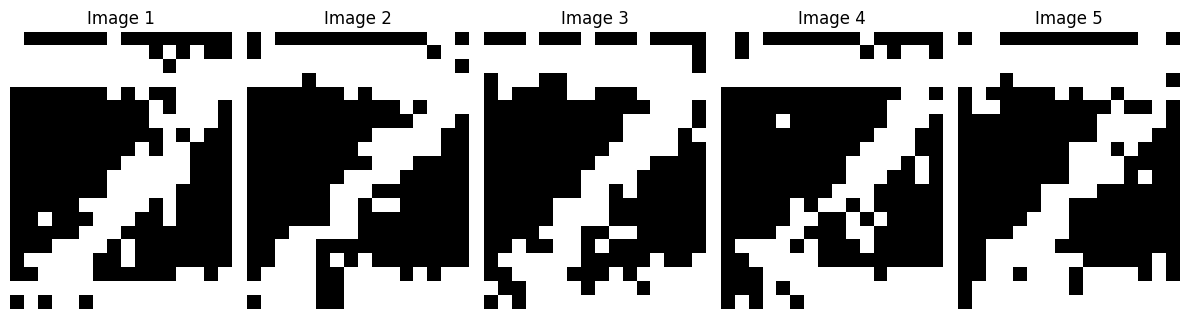

In [48]:
# # Generate images
generated_images = dbn.generate_image(n_samples=5, n_gibbs_steps=1)

# Display generated images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(generated_images[i].reshape(20, 16), cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [49]:
def get_predictions_one_hot(output_probs):
    # Convert softmax probabilities to predictions
    predictions = np.argmax(output_probs, axis=1)
    # Create one-hot encoding
    num_classes = output_probs.shape[1]
    predictions_one_hot = np.eye(num_classes)[predictions]
    return predictions_one_hot

# Example usage:
output_probs = np.array([[0.2, 0.5, 0.3],
                         [0.7, 0.2, 0.1],
                         [0.3, 0.4, 0.3]])

predictions_one_hot = get_predictions_one_hot(output_probs)
print("Predictions (One-Hot):")
print(predictions_one_hot)

Predictions (One-Hot):
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [50]:
def cross_entropy(batch_labels: np.ndarray, output_probs: np.ndarray, eps: float = 1e-15) -> float:
        """
        Calculate the cross entropy between the batch labels and output probabilities.

        Parameters:
        - batch_labels (numpy.ndarray): True labels for the batch, shape (batch_size, n_classes).
        - output_probs (numpy.ndarray): Predicted probabilities for the batch, shape (batch_size, n_classes).
        - eps (float): Small value to avoid numerical instability in logarithm calculation. Default is 1e-15.

        Returns:
        - float: Cross entropy value.
        """
        return -np.mean(np.sum(batch_labels * np.log(output_probs + eps), axis=1))


# Example usage:
# Define true labels and predicted probabilities
batch_labels = np.array([[1, 0, 0], [1, 0, 0], [0, 0, 1]])  # Example one-hot encoded true labels
output_probs = np.array([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.1, 0.1, 0.8]])  # Example softmax output probabilities

# Calculate cross entropy
ce_soft = cross_entropy(batch_labels, output_probs)
ce_hard = cross_entropy(batch_labels, predictions_one_hot)
print("Cross Entropy: (soft)", ce_soft)
print("Cross Entropy: (hard)", ce_hard)

Cross Entropy: (soft) 0.6852416716875042
Cross Entropy: (hard) 23.025850929940457


In [51]:
def sigmoid(x: np.ndarray):
    return 1 / 1 + np.exp(-x)

def sigmoid_derivative(x: np.ndarray):
    return sigmoid(x) * (1 - sigmoid(x))

def accuracy(predictions: np.ndarray, true_labels: np.ndarray) -> float:
    """
    Calculate the accuracy of the model.

    Parameters:
    - predictions (numpy.ndarray): Predicted labels, shape (n_samples, n_classes).
    - true_labels (numpy.ndarray): True labels, shape (n_samples, n_classes).

    Returns:
    - float: Accuracy of the model.
    """
    # Count the number of correct predictions
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == np.argmax(true_labels, axis=1))
    
    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    
    return accuracy


def classification_error_rate(predictions: np.ndarray, true_labels: np.ndarray) -> float:
    """
    Calculate the classification error rate.

    Parameters:
    - predictions (numpy.ndarray): Predicted labels, shape (n_samples, n_classes).
    - true_labels (numpy.ndarray): True labels, shape (n_samples, n_classes).

    Returns:
    - float: Classification error rate.
    """
    # Calculate accuracy
    acc = accuracy(predictions, true_labels)
    
    # Calculate classification error rate
    error_rate = 1 - acc
    
    return error_rate


#### BACKPROPAGATION (CATEGORICAL CROSS ENTROPY)
$$
\begin{align}
dZ^{[l]} = \dfrac{\partial{\mathcal{L}_{CCE}}}{\partial{Z^{[l]}}} &\quad 
dW^{[l]} = \dfrac{\partial{\mathcal{L}_{CCE}}}{\partial{W^{[l]}}} &\quad
db^{[l]} = \dfrac{\partial{\mathcal{L}_{CCE}}}{\partial{b^{[l]}}}
\end{align}
$$

* **Output Layer**
> $$
> \begin{align}
> dZ^{[L]} &= \hat{y} - y := A^{[L]} - y  \\
> dW^{[L]} &= 1/m \times (A^{[L-1]})^{\top} \cdot dZ^{[L]} \\
> db^{[L]} &= 1/m \sum_{i=1}^{m} Row_{i}(dZ^{[L]})   
> \end{align}
> $$

* **Generalization for hidden layer**
> $$
> \begin{align}
> dZ^{[l]} &= dZ^{[l+1]} \cdot (dW^{[l+1]})^{\top} \odot A^{[l]} \odot (1 - A^{[l]}) \\
> dW^{[l]} &= 1/m \times (A^{[l-1]})^{\top} \cdot dZ^{[l]} \\
> db^{[l]} &= 1/m \sum_{i=1}^{m} Row_{i}(dZ^{[l]})
> \end{align}
> $$

* **NOTE**: in the implementation, I used a tiny variable change $dZ' := 1/m \times dZ$.

* ```labels``` $:= y$
* ```output_probs := layer_outputs[-1]``` $:= A_L =: \hat{y}$
* ```layer_outputs``` (L+1 elements) $:= [A^{[0]},A^{[1]},\dots, A^{[L]}] := [X, A^{[1]},\dots, A^{[L-1]}, \hat{y}]$, where $X$ is the input data.
* ```layer_outputs[i]``` := $A^{[i]}$
* ```self.network``` (DNN, L elements) $:= [\mathrm{RBM}^{[1]},\dots,\mathrm{RBM}^{[L]}]$
* ```self.network[s].W``` $:= W^{[s]} := \mathrm{RBM}_{s}.\mathrm{weights}$
* ```self.network[s].b``` $:= b^{[s]} := \mathrm{RBM}_{s}.\mathrm{hidden\_bias}$


- **m = batch_size**
```Python
dZ = (outputs_probs - labels) / batch_size
dW = layer_outputs[-1].T @ dZ 
db = np.sum(dz, axis=0, keepdims=True)
self.network[-1].W -= learning_rate * dW
self.network[-1].b -= learning_rate * db

L = len(layer_outputs)
# Iterate (0, L-2] in reverse order: i.e., index=[L-2, L-1,...,0) // order=[L-1, L-2,...,1)
for id_layer in range(L-2, 0, -1):
    dZ = (dZ @ dW.T) * layer_outputs[id_layer] * (1 - layer_outputs[id_layer]) / batch_size 
    dW = layer_outputs[id_layer - 1].T @ dZ
    db = dZ.sum(axis=0, keepdims=True)
    self.network[-1].W -= learning_rate * dW
    self.network[-1].b -= learning_rate * db

```


In [52]:
# HACK: The current setup requires the network to be pretrained before supervised learning backpropagation. 
# To accommodate this, I distinguish between two components: `self.rbms`, representing pretrainable RBMs, 
# and `self.networks`, which includes the classifier. This allows me to reuse the `train` method inherited 
# from the `DNN` class. However, this leads to an issue: if `self.network` is updated during supervised 
# learning backpropagation, `self.rbms` becomes outdated with respect to `self.network`, and vice versa.
# This setup needs to be reconsidered for better integration and/or synchronization between the RBMs and the network.
# --> For the moment `self.network` is updated during backpropagation then `self.rbms` is synchronized afterwards.

In [65]:
class DNN(DBN):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layer_sizes: List[int],
        random_state=None
    ):
        """
        Initialize the Deep Neural Network (DNN).

        Parameters:
        - input_dim (int): Dimension of the input.
        - output_dim (int): Dimension of the output.
        - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
        - random_state: Random seed for reproducibility.
        """
        super().__init__(
            n_visible=input_dim,
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=random_state
        )
        #--> self.rbms contains only the pre-trainable RBMs 
        self.clf = RBM(self.rbms[-1].n_hidden, output_dim)
        self.network = self.rbms + [self.clf]  # DNN = [DBN + Classifier] ~ [RBM_0,...,RBM_N, RBM_Clf]
        self.dZs = []
        self.dWs = []

    def __getitem__(self, key):
        return self.network[key]
    
    def __len__(self):
        return len(self.network)
    
    def __repr__(self):
        join_repr = "\n".join([f"{'':4}{repr(rbm)}," for rbm in self.network])
        return f"DNN([\n{join_repr} <CLF>\n])"
    
    
    def pretrain(self, n_epochs: int, learning_rate: float, batch_size: int, data: np.ndarray) -> "DNN":
        """
        Pretrain the hidden layers of the DNN using the DBN training method.

        Parameters:
        - n_epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for gradient descent.
        - batch_size (int): Size of mini-batches.
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - DNN: Pretrained DNN instance.
        """
        # NOTE: Use the inherited `train` method to perform pre-training since `self.rbms`
        # only contains the pre-trainable RBMs.
        return self.train(data, n_epochs=n_epochs, learning_rate=learning_rate, batch_size=batch_size)
    
    def input_output_network(self, input_data: np.ndarray) -> List[np.ndarray]:
    def input_output(self, input_data: np.ndarray) -> List[np.ndarray]:
        """
        Get the outputs on each layer of the DNN and the softmax probabilities on the output layer.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - List[np.ndarray]: Input data, outputs on each layer and softmax probabilities.
        """
        layer_outputs = [input_data]

        for rbm in self.rbms:
            layer_outputs.append(rbm.input_output(layer_outputs[-1]))
        
        layer_outputs.append(self.network[-1].calcul_softmax(layer_outputs[-1]))
                
        return layer_outputs

    def update(
            self, 
            dZ_lead: np.ndarray, 
            dW_lead: np.ndarray,
            layer_outputs: List[np.ndarray],
            id_layer: int,
            batch_size: int,
            learning_rate: int
        ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Update the weights and biases of a layer.

        Parameters:
        - dZ_lead (numpy.ndarray): Gradient with respect to the layer's output.
        - dW_lead (numpy.ndarray): Gradient with respect to the layer's weights.
        - layer_outputs (List[np.ndarray]): Outputs of each layer.
        - id_layer (int): Index of the layer.
        - batch_size (int): Size of mini-batches.
        - learning_rate (int): Learning rate.

        Returns:
        - Tuple[np.ndarray, np.ndarray]: Updated gradient with respect to the layer's output and weights.
        """
        # Compute gradient (layer no. `id_layer` + 1)
        dZ = (dZ_lead @ dW_lead.T) * layer_outputs[id_layer] * (1-layer_outputs[id_layer]) / batch_size 
        dW = layer_outputs[id_layer-1].T @ dZ
        db = np.sum(dZ, axis=0, keepdims=True)
        # Update hidden layer weights and biases (layer no. `id_layer` + 1).
        self.network[id_layer].W -= learning_rate * dW
        self.network[id_layer].b -= learning_rate * db
        
        return dZ, dW
    


    def backpropagation(
            self,
            input_data: np.ndarray,
            labels: np.ndarray,
            n_epochs: int=100,
            learning_rate: float=0.1,
            batch_size: int=10,
            eps: float = 1e-15
        ) -> "DNN":
        """
        Estimate the weights/biases of the network using backpropagation algorithm.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - labels (numpy.ndarray): Labels for the input data, shape (n_samples, n_classes).
        - n_epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for gradient descent.
        - batch_size (int): Size of mini-batches.
        - eps (float): Small value to avoid numerical instability in logarithm calculation. Default is 1e-15.

        Returns:
        - DNN: Updated DNN instance.
        """
        n_samples = input_data.shape[0]

        
        for epoch in tqdm(range(n_epochs), desc="Training", unit="epoch"):
            for batch_start in range(0, n_samples, batch_size):
                batch_end = min(batch_start + batch_size, n_samples)
                batch_input = input_data[batch_start:batch_end]
                batch_labels = labels[batch_start:batch_end]

                # Forward pass
                layer_outputs = self.input_output_network(batch_input)
                layer_outputs = self.input_output(batch_input)

                # Backward pass (update weights and biases)
                # Compute output (last) layer gradients (layer L).
                dZ = (layer_outputs[-1] - batch_labels) / batch_size # -> (n_samples, output_dim)
                dW = layer_outputs[-2].T @ dZ # -> (self[-2].n_hidden, self[-1].n_hidden)
                db = np.sum(dZ, axis=0, keepdims=True) # -> (1, self[-1].n_hidden)
                # Update output (last) layer parameters (layer L).
                self.network[-1].W -= learning_rate * dW
                self.network[-1].b -= learning_rate * db

                # Iterate layer in reverse order
                for id_layer in range(-2, -len(self.network)):
                    dZ, dW = self.update(
                        dZ_lead=dZ,
                        dW_lead=dW,
                        id_layer=id_layer,
                        layer_outputs=layer_outputs,
                        batch_size=batch_size,
                        learning_rate=learning_rate
                    )
            
            # HACK: update discrepancy / force 
            self.rbms = self.network[:-1]
            
            # Calculate cross entropy after each epoch
            loss = cross_entropy(batch_labels, layer_outputs[-1], eps)
            tqdm.write(f"Epoch {epoch + 1}/{n_epochs}, Cross Entropy: {loss}")

        return self
    

    def test(self, test_data: np.ndarray, true_labels: np.ndarray) -> float:
        """
        Test the performance of the trained DNN on a test dataset.

        Parameters:
        - test_data (numpy.ndarray): Test data, shape (n_samples, n_visible).
        - true_labels (numpy.ndarray): True labels for the test data,
            shape (n_samples, n_classes).

        Returns:
        - float: Classification error rate.
        """
        # Estimate labels using the trained DNN
        estimated_labels = self.input_output_network(test_data)[-1]

        # Convert softmax probabilities to one-hot encoded predictions
        estimated_labels_one_hot = get_predictions_one_hot(estimated_labels)

        # Calculate classification error rate
        error_rate = classification_error_rate(estimated_labels_one_hot, true_labels)

        return error_rate


In [66]:
n_samples, n_visible = data.shape # n_samples, n_features
hidden_layer_sizes = [100, 50, 25]
output_dim = 20 # n_classes
n_visible=data.shape[1]
hidden_layer_sizes = [100, 50, 25]
output_dim = 20

dnn = DNN(input_dim=n_visible, hidden_layer_sizes=hidden_layer_sizes, output_dim=output_dim, random_state=42)
# keep last RBM's weights for further test.
weights = dnn[-1].W 

dnn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)

# Check that the last RBM has not been trained.
np.testing.assert_equal (dnn[-1].a, 0) # visible bias
np.testing.assert_equal (dnn[-1].b, 0) # hidden bias
np.testing.assert_equal (dnn[-1].W, weights) # weights

Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 800.67it/s]


Reconstruction error: 0.158.
Reconstruction error: 0.17809.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 1996.81it/s]


Reconstruction error: 0.07016.
Reconstruction error: 0.02867.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 4004.11it/s]


Reconstruction error: 0.0058.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 4007.94it/s]


Reconstruction error: 0.00293.


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]


In [67]:
layer_outputs = dnn.input_output_network(data)
layer_outputs = dnn.input_output(data)
n_layers_net = len(layer_outputs) + 1
print("No. network output =", n_layers_net)

print(f"Input data (0): {layer_outputs[0].shape}")
for idx, layer_output in enumerate(layer_outputs[1:]):
    print(f"Hidden layer input ({idx+1}): {layer_output.shape}")

print(f"Softmax output ({n_layers_net - 1}):", layer_outputs[-1].shape)

No. network output = 6
Input data (0): (39, 320)
Hidden layer input (1): (39, 100)
Hidden layer input (2): (39, 50)
Hidden layer input (3): (39, 25)
Hidden layer input (4): (39, 20)
Softmax output (5): (39, 20)


In [68]:
# Define the shape of the array
num_rows = n_samples
num_cols = output_dim
rng = np.random.default_rng(42)

# Generate random hot indices for each row
hot_indices = rng.integers(low=0, high=num_cols, size=num_rows)

# Create the one-hot-encoded array
one_hot_array = np.eye(num_cols)[hot_indices]

print(one_hot_array.shape, one_hot_array.sum(axis=1))
labels = one_hot_array

(39, 20) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [69]:
dnn.backpropagation(data, labels=labels)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1/100, Cross Entropy: 3.008412961901712
Epoch 2/100, Cross Entropy: 2.9730020699906317
Epoch 3/100, Cross Entropy: 2.9471874215444362
Epoch 4/100, Cross Entropy: 2.928470237707137
Epoch 5/100, Cross Entropy: 2.914623835554577
Epoch 6/100, Cross Entropy: 2.9041085702386007
Epoch 7/100, Cross Entropy: 2.8959192087303753
Epoch 8/100, Cross Entropy: 2.8893954870133265


Training:  21%|██        | 21/100 [00:00<00:00, 209.99epoch/s]

Epoch 9/100, Cross Entropy: 2.88409342807027
Epoch 10/100, Cross Entropy: 2.8797070133124745
Epoch 11/100, Cross Entropy: 2.876020669070432
Epoch 12/100, Cross Entropy: 2.8728796488107697
Epoch 13/100, Cross Entropy: 2.87017097791284
Epoch 14/100, Cross Entropy: 2.867810858140453
Epoch 15/100, Cross Entropy: 2.8657361654173257
Epoch 16/100, Cross Entropy: 2.8638986173591037
Epoch 17/100, Cross Entropy: 2.862260720113685
Epoch 18/100, Cross Entropy: 2.860792920109758
Epoch 19/100, Cross Entropy: 2.85947158176382
Epoch 20/100, Cross Entropy: 2.858277537085997
Epoch 21/100, Cross Entropy: 2.857195034824165
Epoch 22/100, Cross Entropy: 2.856210971115255
Epoch 23/100, Cross Entropy: 2.8553143201663302
Epoch 24/100, Cross Entropy: 2.854495708300978
Epoch 25/100, Cross Entropy: 2.8537470916740397
Epoch 26/100, Cross Entropy: 2.853061509637749
Epoch 27/100, Cross Entropy: 2.852432893834761
Epoch 28/100, Cross Entropy: 2.8518559187370736
Epoch 29/100, Cross Entropy: 2.851325883312031
Epoch 30/1

Epoch 32/100, Cross Entropy: 2.84997790547758
Epoch 33/100, Cross Entropy: 2.849598145178248
Epoch 34/100, Cross Entropy: 2.8492484255232395


Training:  21%|██        | 21/100 [00:00<00:00, 209.99epoch/s]

Epoch 35/100, Cross Entropy: 2.8489263128837363
Epoch 36/100, Cross Entropy: 2.8486296024888036
Epoch 37/100, Cross Entropy: 2.848356292264064
Epoch 38/100, Cross Entropy: 2.848104560355906


Epoch 39/100, Cross Entropy: 2.847872745702758
Epoch 40/100, Cross Entropy: 2.8476593311465255
Epoch 41/100, Cross Entropy: 2.847462928678203
Epoch 42/100, Cross Entropy: 2.847282266489771
Epoch 43/100, Cross Entropy: 2.8471161775652813
Epoch 44/100, Cross Entropy: 2.846963589591793
Epoch 45/100, Cross Entropy: 2.8468235160085924
Epoch 46/100, Cross Entropy: 2.846695048043256
Epoch 47/100, Cross Entropy: 2.8465773476072886
Epoch 48/100, Cross Entropy: 2.8464696409436883
Epoch 49/100, Cross Entropy: 2.8463712129347614


Training:  70%|███████   | 70/100 [00:00<00:00, 234.09epoch/s]

Epoch 50/100, Cross Entropy: 2.846281401991663
Epoch 51/100, Cross Entropy: 2.84619959545803
Epoch 52/100, Cross Entropy: 2.846125225469154
Epoch 53/100, Cross Entropy: 2.846057765215788
Epoch 54/100, Cross Entropy: 2.845996725568128
Epoch 55/100, Cross Entropy: 2.845941652021011
Epoch 56/100, Cross Entropy: 2.845892121926082
Epoch 57/100, Cross Entropy: 2.845847741980719
Epoch 58/100, Cross Entropy: 2.845808145947025
Epoch 59/100, Cross Entropy: 2.845772992577216
Epoch 60/100, Cross Entropy: 2.845741963724418
Epoch 61/100, Cross Entropy: 2.845714762620174
Epoch 62/100, Cross Entropy: 2.8456911123020494
Epoch 63/100, Cross Entropy: 2.845670754176465
Epoch 64/100, Cross Entropy: 2.8456534467035306
Epoch 65/100, Cross Entropy: 2.8456389641920192
Epoch 66/100, Cross Entropy: 2.845627095693884
Epoch 67/100, Cross Entropy: 2.8456176439888288
Epoch 68/100, Cross Entropy: 2.8456104246504115
Epoch 69/100, Cross Entropy: 2.8456052651860664
Epoch 70/100, Cross Entropy: 2.8456020042441708
Epoch 7

Training:  70%|███████   | 70/100 [00:00<00:00, 234.09epoch/s]

Epoch 79/100, Cross Entropy: 2.8456361260214083
Epoch 80/100, Cross Entropy: 2.8456449671105246
Epoch 81/100, Cross Entropy: 2.8456544917679594
Epoch 82/100, Cross Entropy: 2.845664628079799


Training:  70%|███████   | 70/100 [00:00<00:00, 234.09epoch/s]

Epoch 83/100, Cross Entropy: 2.845675308952092
Epoch 84/100, Cross Entropy: 2.845686471822368
Epoch 85/100, Cross Entropy: 2.8456980583891465
Epoch 86/100, Cross Entropy: 2.845710014358095


Training:  96%|█████████▌| 96/100 [00:00<00:00, 243.24epoch/s]

Epoch 87/100, Cross Entropy: 2.845722289203636
Epoch 88/100, Cross Entropy: 2.8457348359448944
Epoch 89/100, Cross Entropy: 2.84574761093498
Epoch 90/100, Cross Entropy: 2.8457605736626896
Epoch 91/100, Cross Entropy: 2.8457736865657886
Epoch 92/100, Cross Entropy: 2.8457869148551054
Epoch 93/100, Cross Entropy: 2.845800226348731
Epoch 94/100, Cross Entropy: 2.8458135913156815
Epoch 95/100, Cross Entropy: 2.845826982328421
Epoch 96/100, Cross Entropy: 2.845840374123708
Epoch 97/100, Cross Entropy: 2.8458537434712463
Epoch 98/100, Cross Entropy: 2.845867069049683


Training: 100%|██████████| 100/100 [00:00<00:00, 236.41epoch/s]

Epoch 99/100, Cross Entropy: 2.845880331329516
Epoch 100/100, Cross Entropy: 2.845893512462506


DNN([
    RBM(n_visible=320, n_hidden=100),
    RBM(n_visible=100, n_hidden=50),
    RBM(n_visible=50, n_hidden=25),
    RBM(n_visible=25, n_hidden=20), <CLF>
])

In [70]:
labels.shape, 

((39, 20),)

In [71]:
dnn.test(data, labels)

0.8717948717948718